# Master equation model of the alanine pentapeptide

In this example we deal with a simple but realistic example of MD simulation data, generated with the [Gromacs package](http://www.gromacs.org/).
First we import a number of general purpose Python libraries we will need as we run this example.

In [35]:
%load_ext autoreload
%matplotlib inline
import os
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="ticks", color_codes=True, font_scale=1.5)
sns.set_style({"xtick.direction": "in", "ytick.direction": "in"})

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Next, we download the relevant data from the following [location](https://osf.io/a2vc7/) 

In [2]:
from mastermsm.test.download_data import download_osf_alaTB

In [5]:
try:
    os.mkdir("test")
    download_osf_alaTB()
except FileExistsError:
    pass

### Discretizing the trajectory
We start loading the data using the data structures from the `trajectory` module. For this we use the external library [`MDtraj`](http://mdtraj.org), which contains all sorts of interesting methods for parsing and calculating interestign properties of our time-series data.

In [7]:
from mastermsm.trajectory import traj

In [28]:
tr = traj.TimeSeries(top='test/data/alaTB.gro', \
                     xtc='test/data/alaTB.xtc')
print (tr.mdt)

<mdtraj.Trajectory with 40001 frames, 19 atoms, 3 residues, and unitcells>


To extract the relevant features from the trajectory we use a Featurizer object.

In [29]:
X = traj.Featurizer(tr)

One possibility is to use the torsion angles, which we will shift for convenience.

In [30]:
X.add_torsions(shift=True)

Now our trajectories have a `features` attribute, which contains the $\phi$ and $\psi$ torsions for our residue.

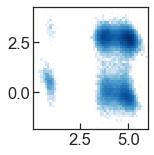

In [39]:
fig, ax = plt.subplots(1,1, figsize=(2.3,2.5))
ax.hist2d(tr.features[:,0], tr.features[:,1], \
                 bins=[50, 50], cmap='Blues', norm=mpl.colors.LogNorm())
plt.tight_layout()

### Core Ramachandran angle regions
Following previous work we can use core regions in the Ramachandran map to define our states. We use utilities from the [MDtraj](http://mdtraj.org) package to compute the Phi and Psi dihedrals.

In [4]:
import mdtraj as md
phi = md.compute_phi(tr.mdt)
psi = md.compute_psi(tr.mdt)
res = [x for x in tr.mdt.topology.residues]

Then we run the actual discretization, using only two states for the alpha and extended conformations.

In [5]:
tr.discretize(states=['A', 'E', 'L'])
tr.find_keys()

AttributeError: 'TimeSeries' object has no attribute 'discretize'

In [ ]:
fig, ax = plt.subplots(figsize=(10,3))
ax.plot(tr.mdt.time, [tr.keys.index(x) if (x in tr.keys) else 0 for x in tr.distraj ], lw=1)
ax.set_xlim(0, 1.5e5)
ax.set_ylim(-0.5, 2.5)
ax.set_yticks(range(3))
ax.set_yticklabels(['A', 'E', 'L'])
ax.set_xlabel('Time (ps)', fontsize=20)
ax.set_ylabel('state', fontsize=20)

Finally we derive the MSM using the tools from the ```msm``` module. In particular, we use the ```SuperMSM``` class that will help build MSMs at various lag times.

In [ ]:
from mastermsm.msm import msm
msm_alaTB = msm.SuperMSM([tr])
for i in [1, 2, 5, 10, 20, 50, 100]:
    msm_alaTB.do_msm(i)
    msm_alaTB.msms[i].do_trans()
    msm_alaTB.msms[i].boots()

Next we gather results from all these MSMs and plot the relaxation time corresponding to the two slow transitions.

In [ ]:
fig, ax = plt.subplots()
tau_vs_lagt = np.array([[x,msm_alaTB.msms[x].tauT[0],msm_alaTB.msms[x].tau_std[0]] \
               for x in sorted(msm_alaTB.msms.keys())])
ax.errorbar(tau_vs_lagt[:,0],tau_vs_lagt[:,1],fmt='o-', yerr=tau_vs_lagt[:,2], markersize=10)
tau_vs_lagt = np.array([[x,msm_alaTB.msms[x].tauT[1],msm_alaTB.msms[x].tau_std[1]] \
               for x in sorted(msm_alaTB.msms.keys())])
ax.errorbar(tau_vs_lagt[:,0],tau_vs_lagt[:,1],fmt='o-', yerr=tau_vs_lagt[:,2], markersize=10)
ax.fill_between(10**np.arange(-0.2,3,0.2), 1e-1, 10**np.arange(-0.2,3,0.2), facecolor='lightgray')
ax.set_xlabel(r'$\Delta$t [ps]', fontsize=16)
ax.set_ylabel(r'$\tau$ [ps]', fontsize=16)
ax.set_xlim(0.8,150)
ax.set_ylim(10,3000)
ax.set_yscale('log')
_ = ax.set_xscale('log')

### Fine grid on the Ramachandran map
Alternatively we can make a grid on the Ramachandran map with many more states.

In [ ]:
tr.discretize(method="ramagrid", nbins=30)
tr.find_keys()

In [ ]:
fig, ax = plt.subplots(figsize=(10,3))
ax.plot(tr.mdt.time, [x for x in tr.distraj], '.', ms=1)
ax.set_xlim(0, 1.5e5)
ax.set_ylim(-1, 900)
ax.set_xlabel('Time (ps)', fontsize=20)
ax.set_ylabel('state', fontsize=20)

Then we repeat the same steps as before, but with this fine grained MSM.

In [ ]:
from mastermsm.msm import msm
msm_alaTB_grid = msm.SuperMSM([tr])
for i in [1, 2, 5, 10, 20, 50, 100]:
    msm_alaTB_grid.do_msm(i)
    msm_alaTB_grid.msms[i].do_trans()
    msm_alaTB_grid.msms[i].boots()

First we take a look at the dependence of the slowest relaxation time with the lag time, $\Delta t$ for the construction of the Markov model as a minimal quality control.

In [ ]:
tau1_vs_lagt = np.array([[x, msm_alaTB_grid.msms[x].tauT[0], \
                    msm_alaTB_grid.msms[x].tau_std[0]] \
                   for x in sorted(msm_alaTB_grid.msms.keys())])
tau2_vs_lagt = np.array([[x, msm_alaTB_grid.msms[x].tauT[1], \
                    msm_alaTB_grid.msms[x].tau_std[1]] \
                   for x in sorted(msm_alaTB_grid.msms.keys())])
tau3_vs_lagt = np.array([[x,msm_alaTB_grid.msms[x].tauT[2], \
                    msm_alaTB_grid.msms[x].tau_std[2]] \
                   for x in sorted(msm_alaTB_grid.msms.keys())])
tau4_vs_lagt = np.array([[x,msm_alaTB_grid.msms[x].tauT[3], \
                    msm_alaTB_grid.msms[x].tau_std[3]] \
                   for x in sorted(msm_alaTB_grid.msms.keys())])

fig, ax = plt.subplots()
ax.errorbar(tau1_vs_lagt[:,0],tau1_vs_lagt[:,1], tau1_vs_lagt[:,2], fmt='o-', markersize=10)
ax.errorbar(tau2_vs_lagt[:,0],tau2_vs_lagt[:,1], tau2_vs_lagt[:,2], fmt='o-', markersize=10)
ax.errorbar(tau3_vs_lagt[:,0],tau3_vs_lagt[:,1], tau3_vs_lagt[:,2], fmt='o-', markersize=10)
ax.errorbar(tau4_vs_lagt[:,0],tau4_vs_lagt[:,1], tau4_vs_lagt[:,2], fmt='o-', markersize=10)
ax.fill_between(10**np.arange(-0.2,3,0.2), 1e-1, 10**np.arange(-0.2,3,0.2), facecolor='lightgray', alpha=0.5)
ax.set_xlabel(r'$\Delta$t [ps]', fontsize=16)
ax.set_ylabel(r'$\tau_i$ [ps]', fontsize=16)
ax.set_xlim(0.8,200)
ax.set_ylim(1,3000)
_ = ax.set_xscale('log')
_ = ax.set_yscale('log')
plt.tight_layout()

The slowest relaxation times from the fine-grained MSM agree with those of the core regions, although in this case there is an additional slow mode.

In [ ]:
fig, ax = plt.subplots()
ax.errorbar(range(1,16),msm_alaTB_grid.msms[10].tauT[0:15], fmt='o-', \
            yerr= msm_alaTB_grid.msms[10].tau_std[0:15], ms=10)
ax.set_xlabel('Eigenvalue index')
ax.set_ylabel(r'$\tau_i$ (ns)')
ax.set_yscale('log')
plt.tight_layout()

We can understand which dynamical processes the eigenvectors are associated to by looking at the corresponding eigenvectors. For this we recalculate the transition matrix but now recovering the eigenvectors. 

In [ ]:
msm_alaTB_grid.msms[10].do_trans(evecs=True)

In [ ]:
fig, ax = plt.subplots(1,4, figsize=(12,3), sharex=True, sharey=True)
mat = np.zeros((30,30), float)
for i in [x for x in zip(msm_alaTB_grid.msms[10].keep_keys, \
                         msm_alaTB_grid.msms[10].rvecsT[:,0])]:
    #print i, i[0]%20, int(i[0]/20), -i[1]

    mat[i[0]%30, int(i[0]/30)] = i[1]
ax[0].imshow(mat.transpose(), interpolation="none", origin='lower', \
             cmap='Blues')
ax[0].set_title(r"$\psi_1$")

mat = np.zeros((30,30), float)
for i in [x for x in zip(msm_alaTB_grid.msms[10].keep_keys, \
                         msm_alaTB_grid.msms[10].rvecsT[:,1])]:
    #print i, i[0]%20, int(i[0]/20), -i[1]
    mat[i[0]%30, int(i[0]/30)] = -i[1]
ax[1].imshow(mat.transpose(), interpolation="none", origin='lower', \
             cmap='RdBu')
ax[1].set_title(r"$\psi_2$")

mat = np.zeros((30,30), float)
for i in [x for x in zip(msm_alaTB_grid.msms[10].keep_keys, \
                         msm_alaTB_grid.msms[10].rvecsT[:,2])]:
    #print i, i[0]%20, int(i[0]/20), -i[1]
    mat[i[0]%30, int(i[0]/30)] = -i[1]
ax[2].imshow(mat.transpose(), interpolation="none", origin='lower', \
                 cmap='RdBu')
ax[2].set_title(r"$\psi_3$")

mat = np.zeros((30,30), float)
for i in [x for x in zip(msm_alaTB_grid.msms[10].keep_keys, \
                         msm_alaTB_grid.msms[10].rvecsT[:,3])]:
    #print i, i[0]%20, int(i[0]/20), -i[1]
    mat[i[0]%30, int(i[0]/30)] = -i[1]
ax[3].imshow(mat.transpose(), interpolation="none", origin='lower', \
                 cmap='RdBu')
ax[3].set_title(r"$\psi_4$")

Here we are plotting the values of the eigenvectors so that the state indexes match the positions in the Ramachandran map. On the left, we show the stationary eigenvector, $\psi_1$, which is proportional to the equilibrium population. The other three plots correspond to the slowest dynamical modes. From $\psi_2$, we find that the slowest transition is the interconversion between the $\alpha_L$ and the $\alpha_R/\beta$ states. These, equilibrate more rapidly, as indicated by $\psi_3$. Finally, on the right, we find the additional mode that corresponds to a yet faster transition between the $\alpha_L$ basin and a fourth Ramachandran region.

### Clustering
So it seems three states only may not be a very good clustering for this particular system. Maybe we need one more. In order to do the clustering systematically we use the ```fewsm``` module from ```MasterMSM```. From the eigenvectors we are immediately able to produce a sensible, albeit still imperfect, partitioning in four states.

In [ ]:
from mastermsm.fewsm import fewsm

In [ ]:
fewsm4 = fewsm.FEWSM(msm_alaTB_grid.msms[2], N=4)

In [ ]:
import matplotlib.cm as cm
fig, ax = plt.subplots(figsize=(5,5))
mat = np.zeros((30,30), float)
for i in msm_alaTB_grid.msms[2].keep_keys:
    j = msm_alaTB_grid.msms[2].keep_keys.index(i)
    if j in fewsm4.macros[0]:
        mat[i%30, int(i/30)] = 1
    elif j in fewsm4.macros[1]:
        mat[i%30, int(i/30)] = 2
    elif j in fewsm4.macros[2]:
        mat[i%30, int(i/30)] = 3
    else:
        mat[i%30, int(i/30)] = 4
    #print i, i[0]%20, int(i[0]/20), -i[1]
my_cmap = cm.get_cmap('viridis')
my_cmap.set_under('w')
ax.imshow(mat.transpose(), interpolation="none", origin='lower', \
             cmap=my_cmap, vmin = 0.5)

Note how the partitioning based on eigenvectors captures the three important regions in the Ramachandran map.